In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np
from glob import glob
from os.path import join 
import os 
from scikits.bootstrap import ci
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from plotResults import *

### 1. Visualization

In [5]:
models_dir = sorted(glob("results/newlbls-fu3-espad-fu3-19a-binge-*/*/"))[-1]
models_dir

'results/newlbls-fu3-espad-fu3-19a-binge-n650/20210618-1730/'

#### 1.1 probability distributions

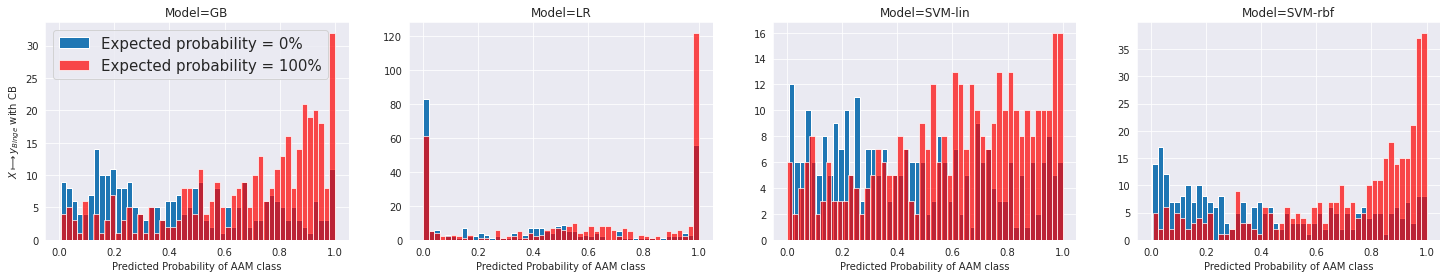

In [6]:
df = pd.read_csv(models_dir+"/run.csv")

grp_order = ["io", "technique", "model"]
groups = df.groupby(grp_order)   
n_models = len(df["model"].unique())
n_rows = round(len(groups)/n_models)
fig, axes = plt.subplots(n_rows, n_models, 
                         sharex=True, sharey=False,
                         figsize=(25, n_models*n_rows))
axes = np.ravel(axes)
        
for i, (g, dfi) in enumerate(groups):
    ids_all = np.array([id_lists for ids in dfi["test_ids"] for id_lists in eval(ids)])
    assert ids_all.shape[0] == np.unique(ids_all).shape[0]
    probs_all = np.array([prob_lists for probs in dfi["test_probs"] for prob_lists in eval(probs)])
    y_all = np.array([y_lists for y in dfi["test_lbls"] for y_lists in eval(y)])
    assert probs_all.shape[0] == y_all.shape[0]

    prediction=probs_all[:,1]
    ax = axes[i]
    ax.hist(prediction[y_all==0], bins=50, label='Expected probability = 0%')
    ax.hist(prediction[y_all==1], bins=50, label='Expected probability = 100%', alpha=0.7, color='r')
    ax.set_xlabel('Predicted Probability of AAM class')
    if i%n_models == 0:
        ax.set_ylabel("{} with {}".format(remap_io(dfi.iloc[0]), g[1].upper()))
    if i == 0:
        ax.legend(fontsize=15)
    ax.set_title("Model={}".format(g[-1]))
    
plt.show() 

### 1.2 SHAP values
 1. what is the best/fastest estimator for my 4 models?
 2. how to save and load SHAP values?
 3. What to visualize?

In [5]:
import shap

In [6]:
# load all trained models
from joblib import load 

models = {}
model_names = list(set([f.split("_")[0] for f in os.listdir(models_dir) if f.split(".")[-1]=="model"]))
for model_name in model_names:
    models.update({model_name: [load(f) for f in glob(models_dir+f"/{model_name}_*.model")]})

models['LR'][0]

Pipeline(steps=[('varth', VarianceThreshold()), ('scale', StandardScaler()),
                ('conf_corr_cb',
                 CounterBalance(oversample=True, random_state=9)),
                ('model_LR', LogisticRegression(max_iter=1000))])

In [7]:
# load the training data
import h5py

h5_dir = "/ritter/share/data/IMAGEN/h5files/" + models_dir.split("/")[-3] + ".h5"
data = h5py.File(h5_dir, 'r')
data.keys(), data.attrs.keys()

(<KeysViewHDF5 ['Binge', 'X', 'i', 'sex', 'site']>,
 <KeysViewHDF5 ['X_col_names', 'confs', 'labels']>)

In [8]:
X = data['X'][()]
y = data[data.attrs['labels'][0]][()]
X_col_names = data.attrs['X_col_names'][()]

X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

X.shape, y.shape, len(X_col_names)

((624, 725), (624,), 725)

In [ ]:
# load the holdout data


In [ ]:
shap_values_stored = {}

for model_name in models:
    print("generating SHAP plots for model = {} ..".format(model_name))
    if "GB" not in model_name:
        print("skipping model {} as it takes too long".format(model_name))
        continue
    for i, model in enumerate(models[model_name]):
        print(model)
        explainer = shap.Explainer(model.predict, X100, output_names=["Healthy","AUD-risk"])
        shap_values = explainer(X)
        shap_values_stored.update({model_name+str(i): shap_values})
#         if ('model_LR' in model.steps):
#             # plot the coefs of Logistic Regression
#             coefs = {}
#             for i in range(model['model_LR'].coef_.shape[-1]):
#                 coefs.update({X_col_names[i] : model['model_LR'].coef_[0,i].round(4)})
#             pd.Series(coefs).sort_values(key=np.abs)[-15:].plot.barh(title="Model coefficients:")
#             plt.show()

generating SHAP plots for model = GB ..
Pipeline(steps=[('varth', VarianceThreshold()), ('scale', StandardScaler()),
                ('conf_corr_cb',
                 CounterBalance(oversample=True, random_state=38)),
                ('model_GB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.25,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=48, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                             

Permutation explainer:   1%|          | 6/624 [03:35<6:32:26, 38.10s/it]

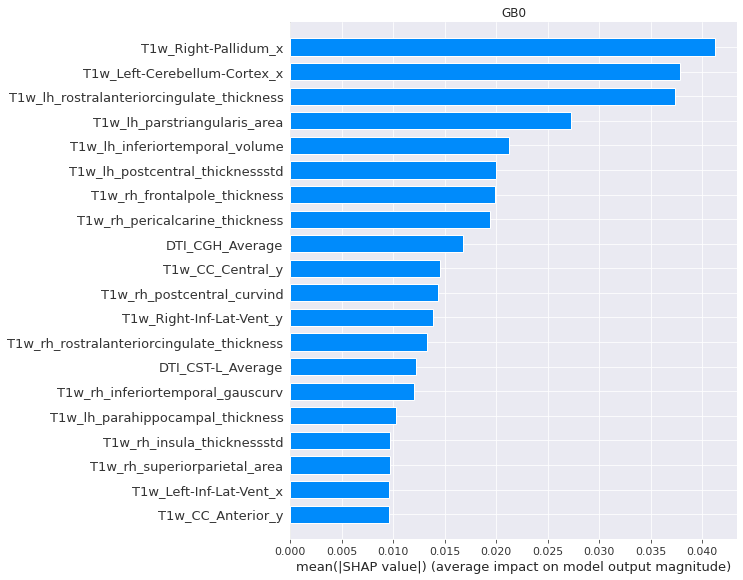

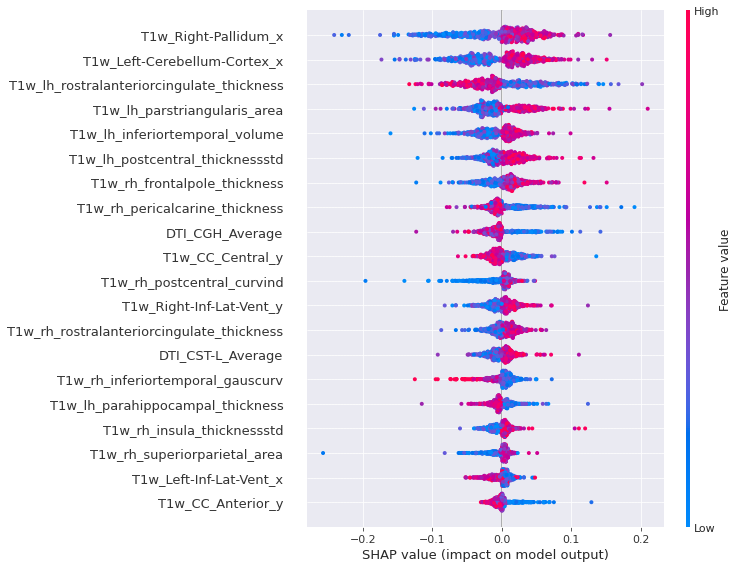

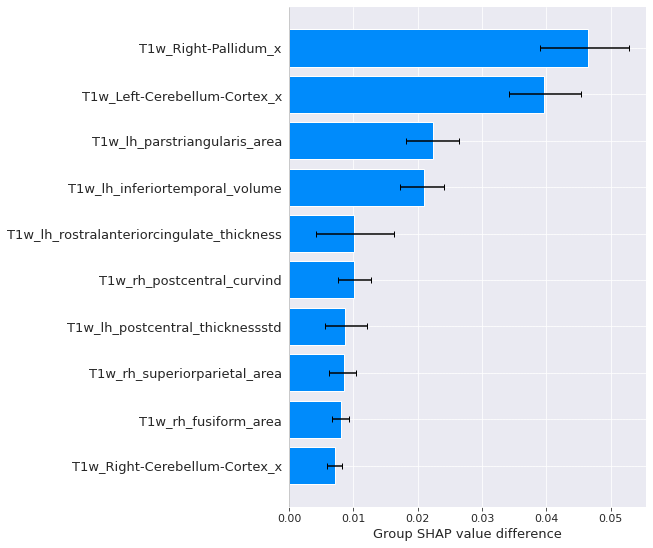

In [17]:
for k in shap_values_stored:
    shap_values = shap_values_stored[k]
    plt.title(k)
    shap.summary_plot(shap_values, features=X, feature_names=X_col_names, plot_type="bar")
    plt.show()
    shap.summary_plot(shap_values, features=X, feature_names=X_col_names, plot_type="dot")
    plt.show() #plt.savefig("viz/{}_{}_dot.pdf".format(model_name,str(i)))
    shap.group_difference_plot(shap_values.values, group_mask=data['sex'][()].astype(bool), 
                       feature_names=X_col_names, max_display=10)
    plt.show() #plt.savefig("viz/{}_{}_sexdiff.pdf".format(model_name,str(i)))


In [12]:
model = models['GB'][0]

In [26]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100, output_names=["Healthy","AUD-risk"])

In [ ]:
shap_values = explainer(X)

Permutation explainer:  28%|██▊       | 186/668 [2:02:02<5:22:32, 40.15s/it]

In [ ]:
# for i, sub in enumerate(shap_values): #.values.shape
#     print("sub idx={}".format(i))
#     for j, feature in enumerate(sub):
#         print("feature idx={}".format(j))
#         display(type(feature), feature)
        

# shap_values[...,0]

In [53]:
# clustering = shap.utils.hclust(X, y)

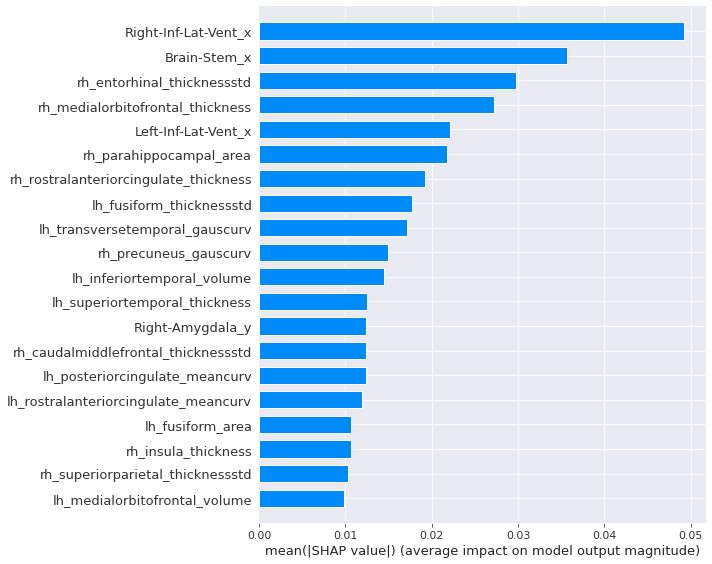

In [64]:
shap.summary_plot(shap_values, features=X, feature_names=X_col_names, plot_type="bar")

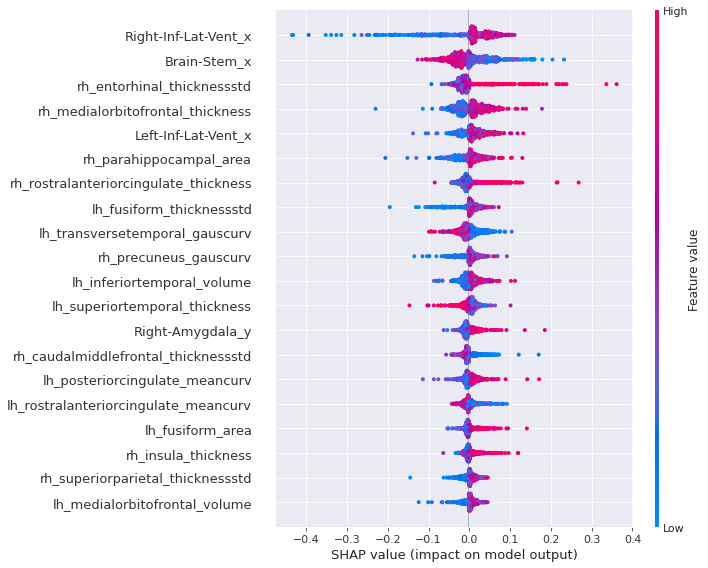

In [51]:
shap.summary_plot(shap_values, features=X, feature_names=X_col_names, plot_type="dot")

FixedFormatter should only be used together with FixedLocator


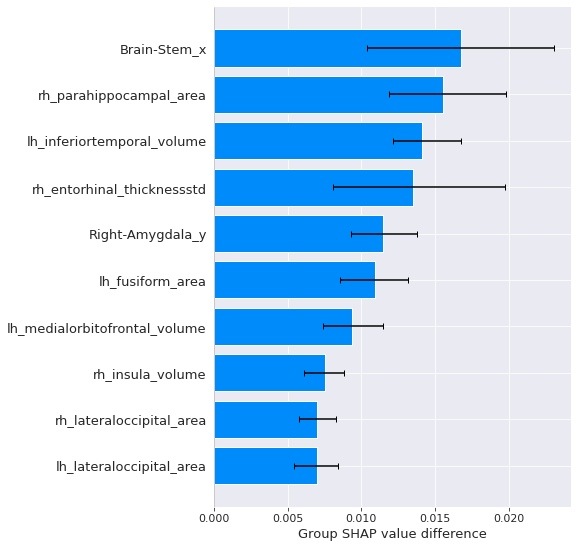

In [63]:
shap.group_difference_plot(shap_values.values, group_mask=data['sex'][()].astype(bool), 
                           feature_names=X_col_names, max_display=10)

In [62]:
# individual features
# shap.embedding_plot(396, shap_values.values, feature_names=X_col_names)
# shap.dependence_plot(ind, shap_values=None, features=None, feature_names=None, display_features=None)
# individual subject predictions
#  shap.waterfall_plot(shap_values, max_display=10, show=True)

In [77]:
model = models['LR'][0]
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100, output_names=["Healthy","AUD-risk"], feature_names=X_col_names)

In [ ]:
shap_values_lr = explainer(X)

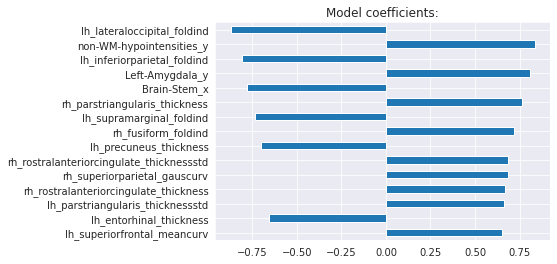

In [98]:
# plot the coefs of Logistic Regression
coefs = {}

for i in range(model['model_LR'].coef_.shape[-1]):
    coefs.update({X_col_names[i] : model['model_LR'].coef_[0,i].round(4)})
pd.Series(coefs).sort_values(key=np.abs)[-15:].plot.barh(title="Model coefficients:")
plt.show()

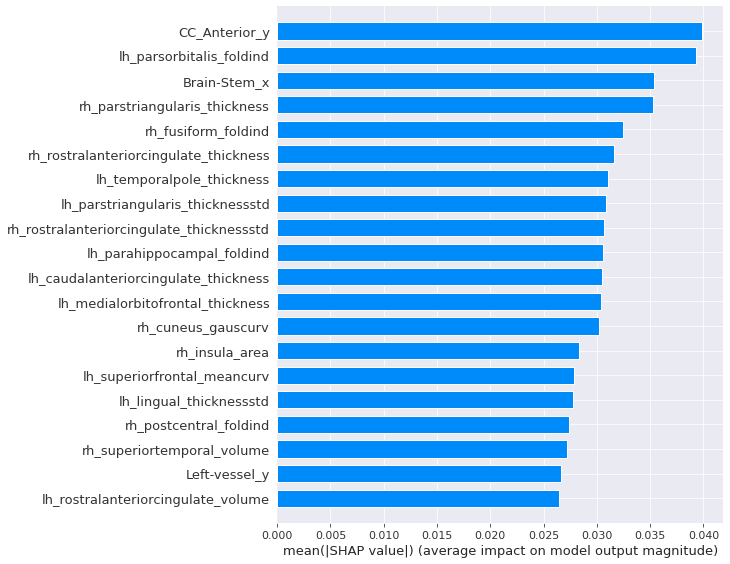

In [71]:
shap.summary_plot(shap_values_lr, features=X, feature_names=X_col_names, plot_type="bar")

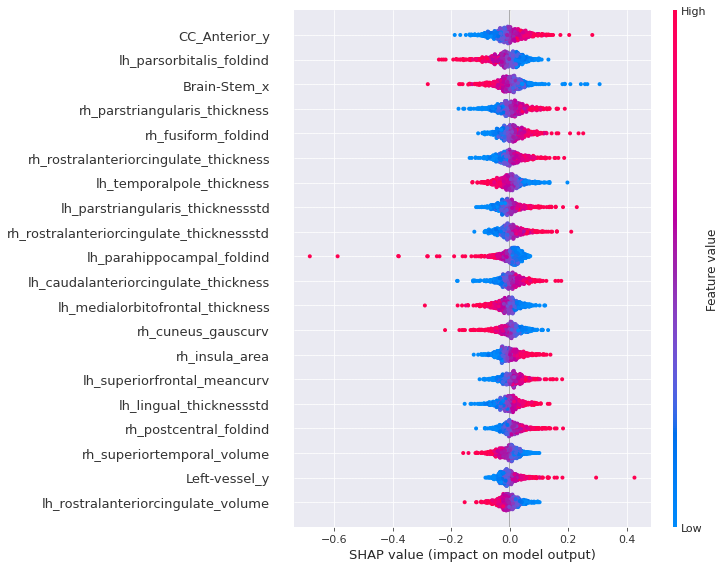

In [72]:
shap.summary_plot(shap_values_lr, features=X, feature_names=X_col_names, plot_type="dot")

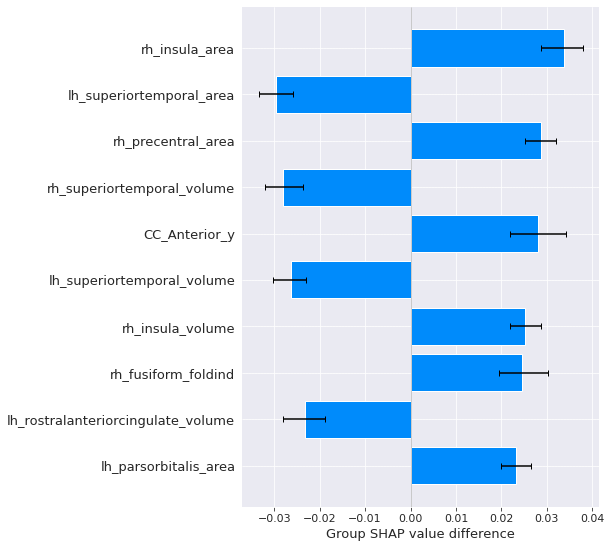

In [74]:
shap.group_difference_plot(shap_values_lr.values, group_mask=data['sex'][()].astype(bool), 
                           feature_names=X_col_names, max_display=10)

In [99]:
model = models['SVM-rbf'][0]
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100, output_names=["Healthy","AUD-risk"], feature_names=X_col_names)

In [ ]:
shap_values_svmrbf = explainer(X)

Permutation explainer:  13%|█▎        | 85/668 [8:26:29<58:12:32, 359.44s/it]

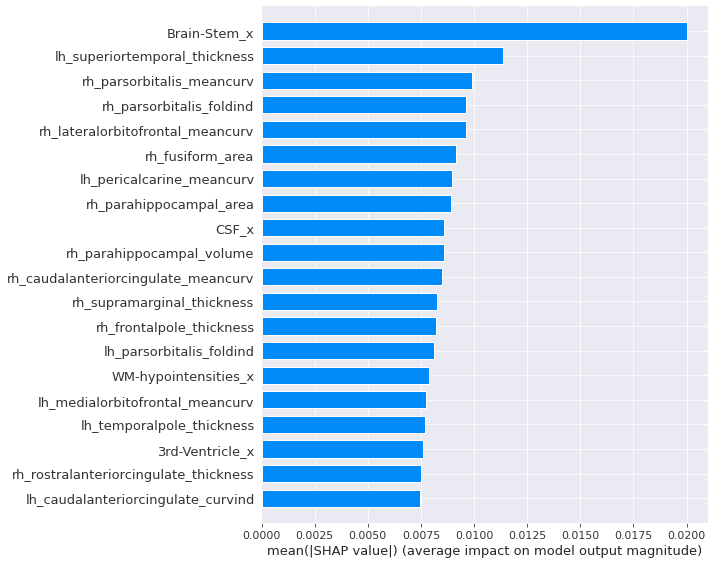

In [105]:
shap.summary_plot(shap_values_svmrbf, features=X, feature_names=X_col_names, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values_svmrbf, features=X, feature_names=X_col_names, plot_type="dot")

In [ ]:
shap.group_difference_plot(shap_values_svmrbf.values, group_mask=data['sex'][()].astype(bool), 
                           feature_names=X_col_names, max_display=10)

---

In [ ]:
model = models['SVM-lin'][0]
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100, output_names=["Healthy","AUD-risk"], feature_names=X_col_names)
shap_values_svmlin = explainer(X)

In [ ]:
shap.summary_plot(shap_values_svmlin, features=X, feature_names=X_col_names, plot_type="bar")
shap.summary_plot(shap_values_svmlin, features=X, feature_names=X_col_names, plot_type="dot")
shap.group_difference_plot(shap_values_svmlin.values, group_mask=data['sex'][()].astype(bool), 
                           feature_names=X_col_names, max_display=10)